# Explore here

In [24]:
# 1 import / install libraries
!pip install pandas numpy matplotlib seaborn
!pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [36]:
#2 Load the dataset directly from the URL
url = "https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv"
df = pd.read_csv(url, sep=';') 

print("\n--- Columns in the DataFrame ---")
df.columns

# Display the first 5 rows to get a feel for the data
print("--- First 5 rows of the dataset ---")
df.head()


--- Columns in the DataFrame ---
--- First 5 rows of the dataset ---


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [37]:
# Get a concise summary of the DataFrame (data types, non-null values)
print("\n--- Dataset Information ---")
df.info()

# Check the distribution of the target variable 'y'
print("\n--- Distribution of the Target Variable 'y' ---")
print(df['y'].value_counts())
print(df['y'].value_counts(normalize=True))


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  co

3. Perform a full EDA (Exploratory Data Analysis)

# --- 3.1 EDA for Numerical Features ---

In [39]:
print("\n--- 3.1 Descriptive Statistics for Numerical Features ---")
df.describe()


--- 3.1 Descriptive Statistics for Numerical Features ---


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


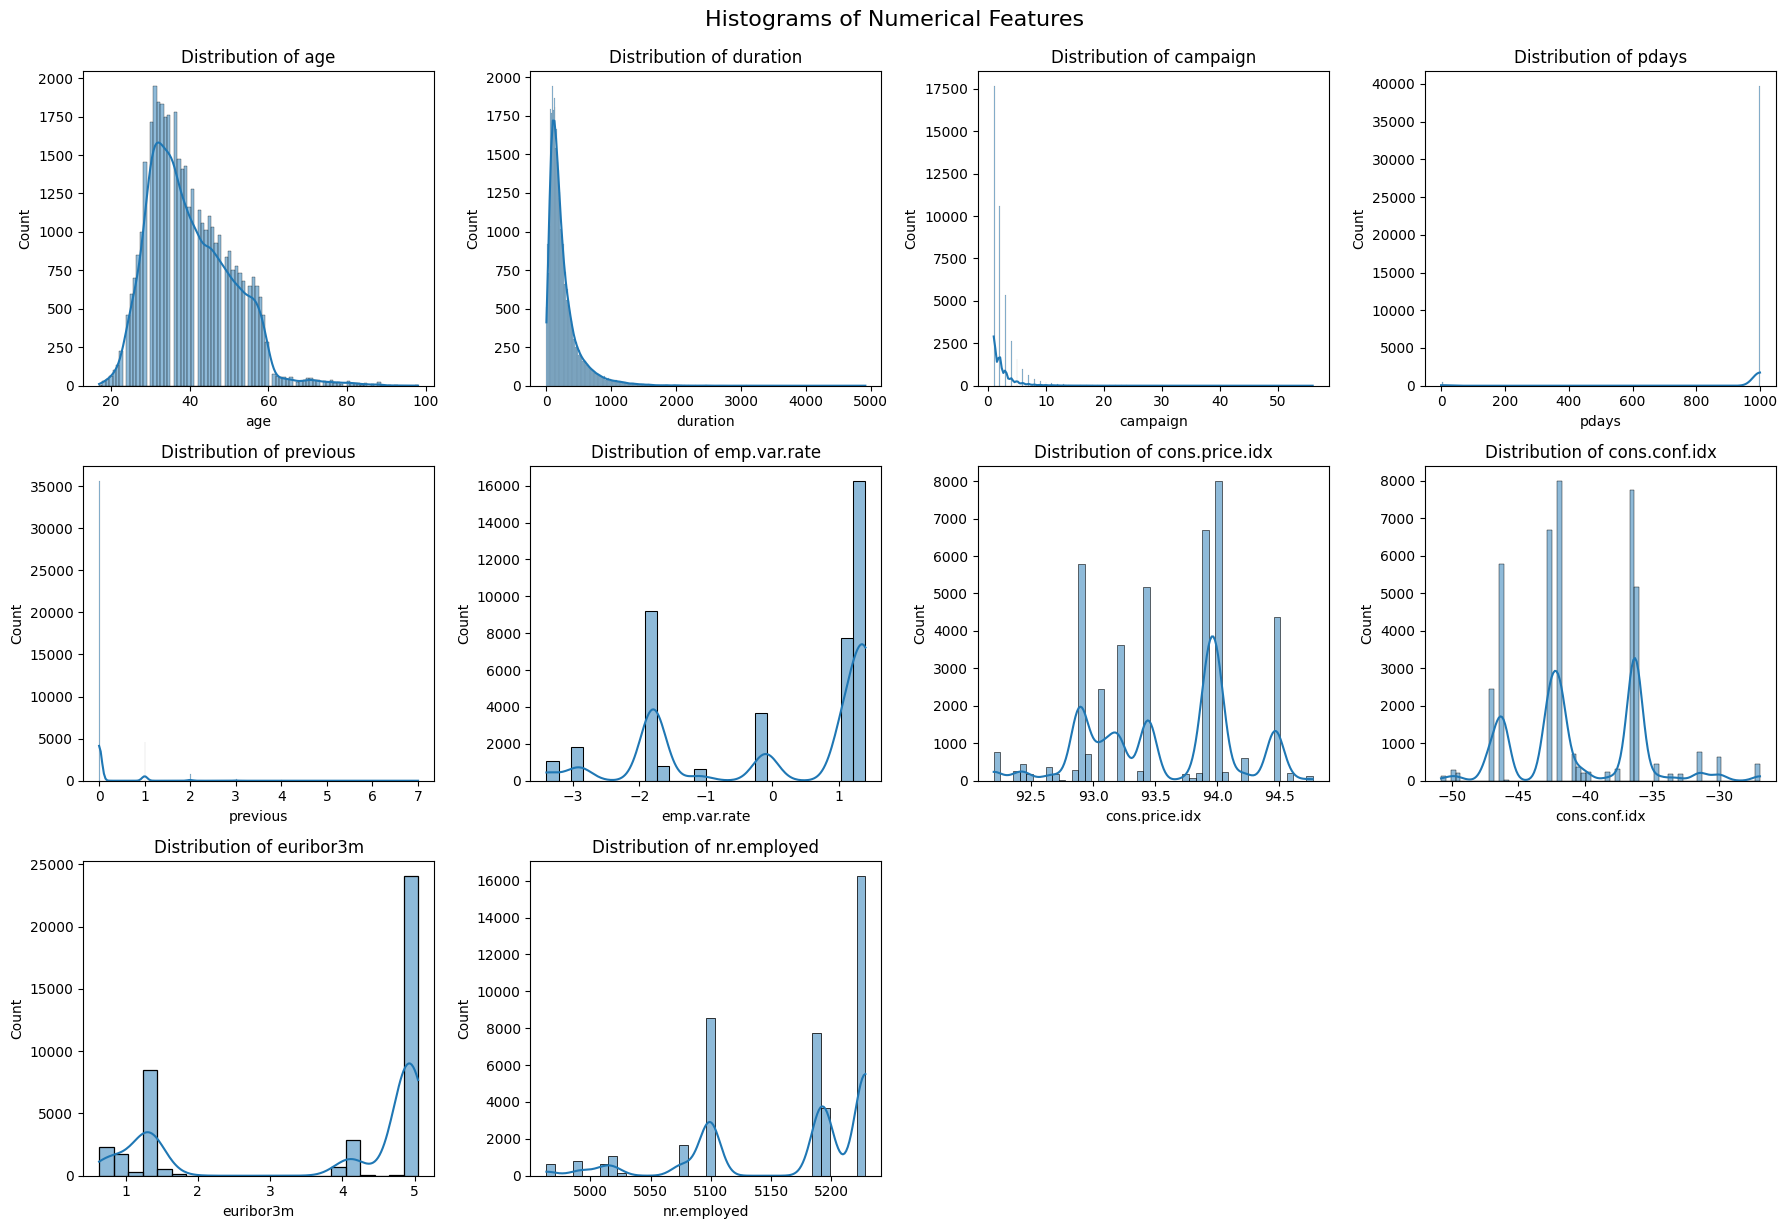

In [40]:
# List of numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.suptitle('Histograms of Numerical Features', y=1.02, fontsize=16)
plt.show()


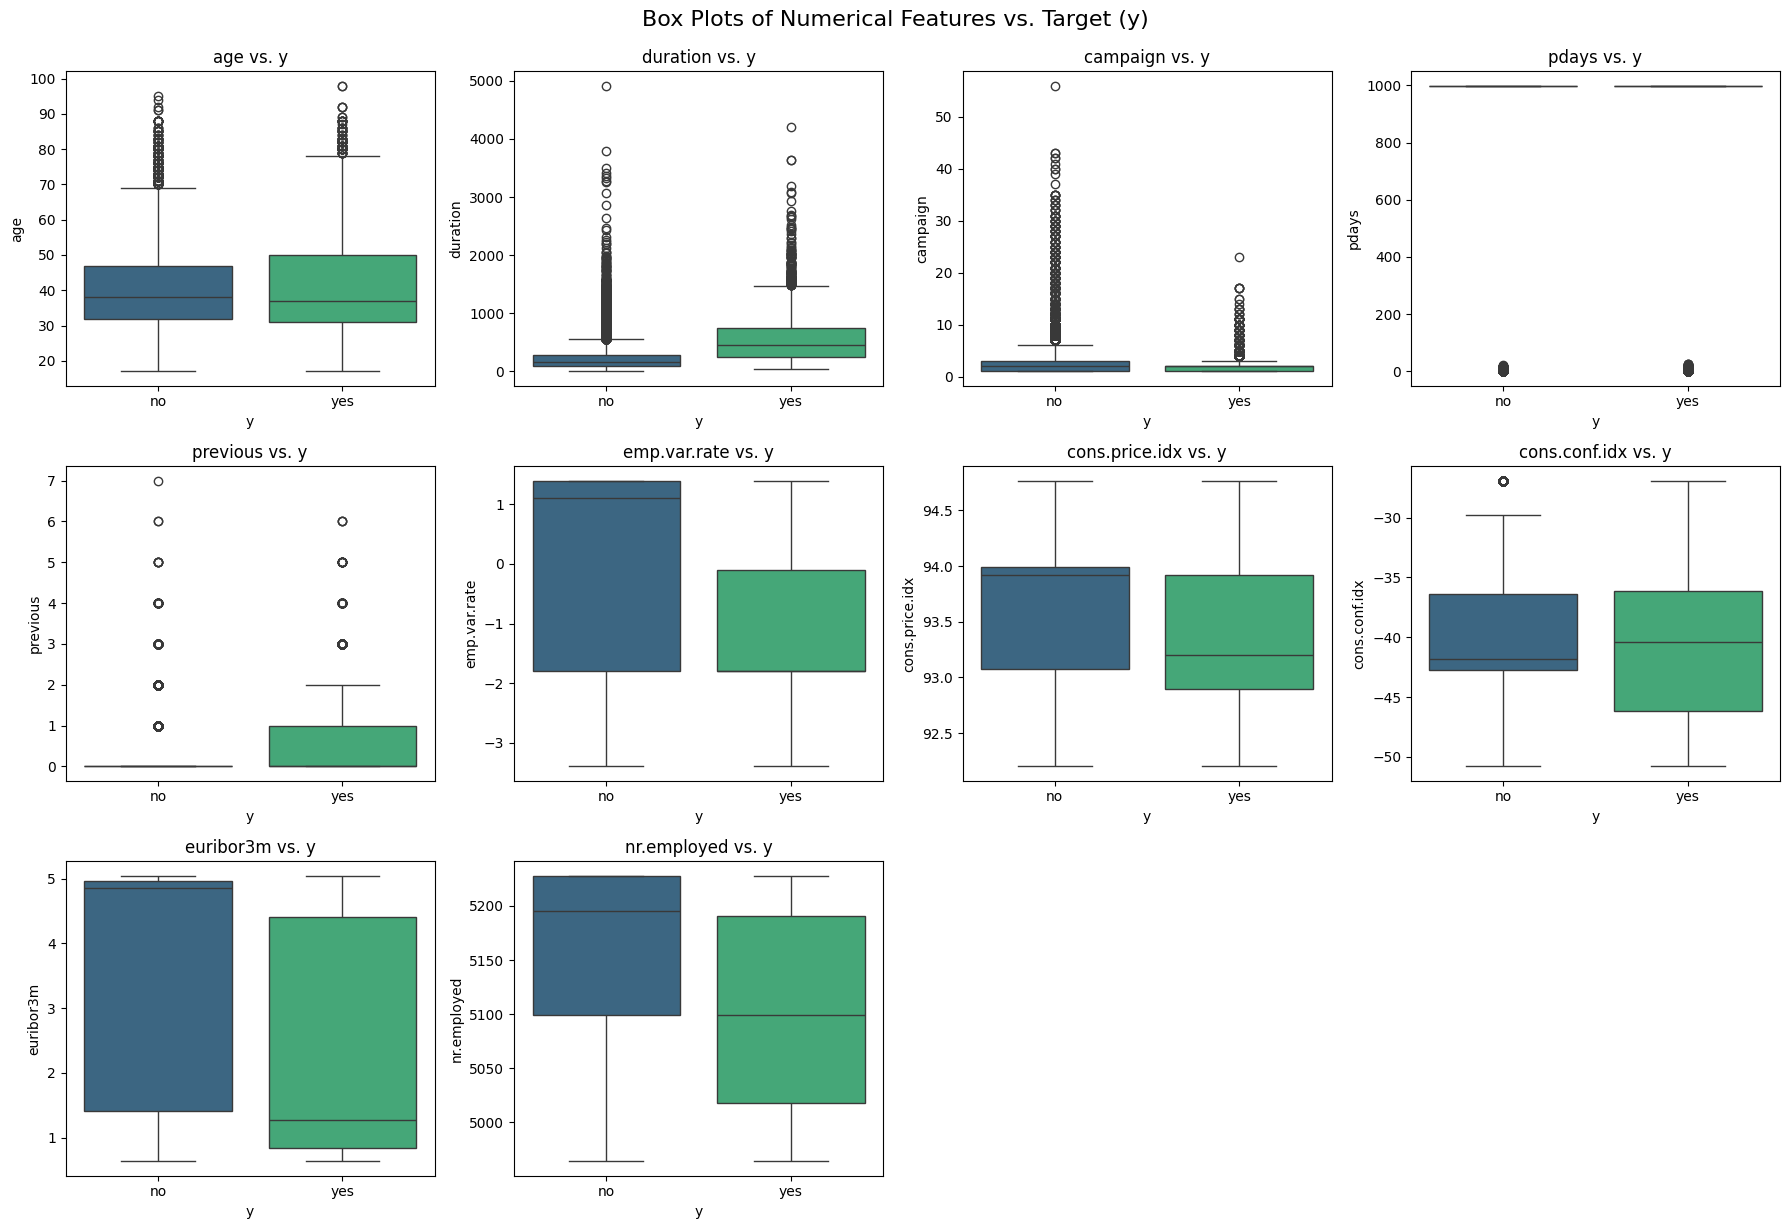

In [41]:
# Relationship between Numerical Features and Target Variable
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='y', y=col, data=df, palette='viridis', hue='y', legend=False)
    plt.title(f'{col} vs. y')
plt.tight_layout()
plt.suptitle('Box Plots of Numerical Features vs. Target (y)', y=1.02, fontsize=16)
plt.show()


--- 3.2 Value Counts for Categorical Features ---

job:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
job
admin.           0.253035
blue-collar      0.224677
technician       0.163713
services         0.096363
management       0.070992
retired          0.041760
entrepreneur     0.035350
self-employed    0.034500
housemaid        0.025736
unemployed       0.024619
student          0.021244
unknown          0.008012
Name: proportion, dtype: float64

marital:
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64
marital
married     0.605225
single      0.280859
divorced    0.111974
unknown     0.001942
Name: proportion, dtype: float64

education:
education
university.degree      12

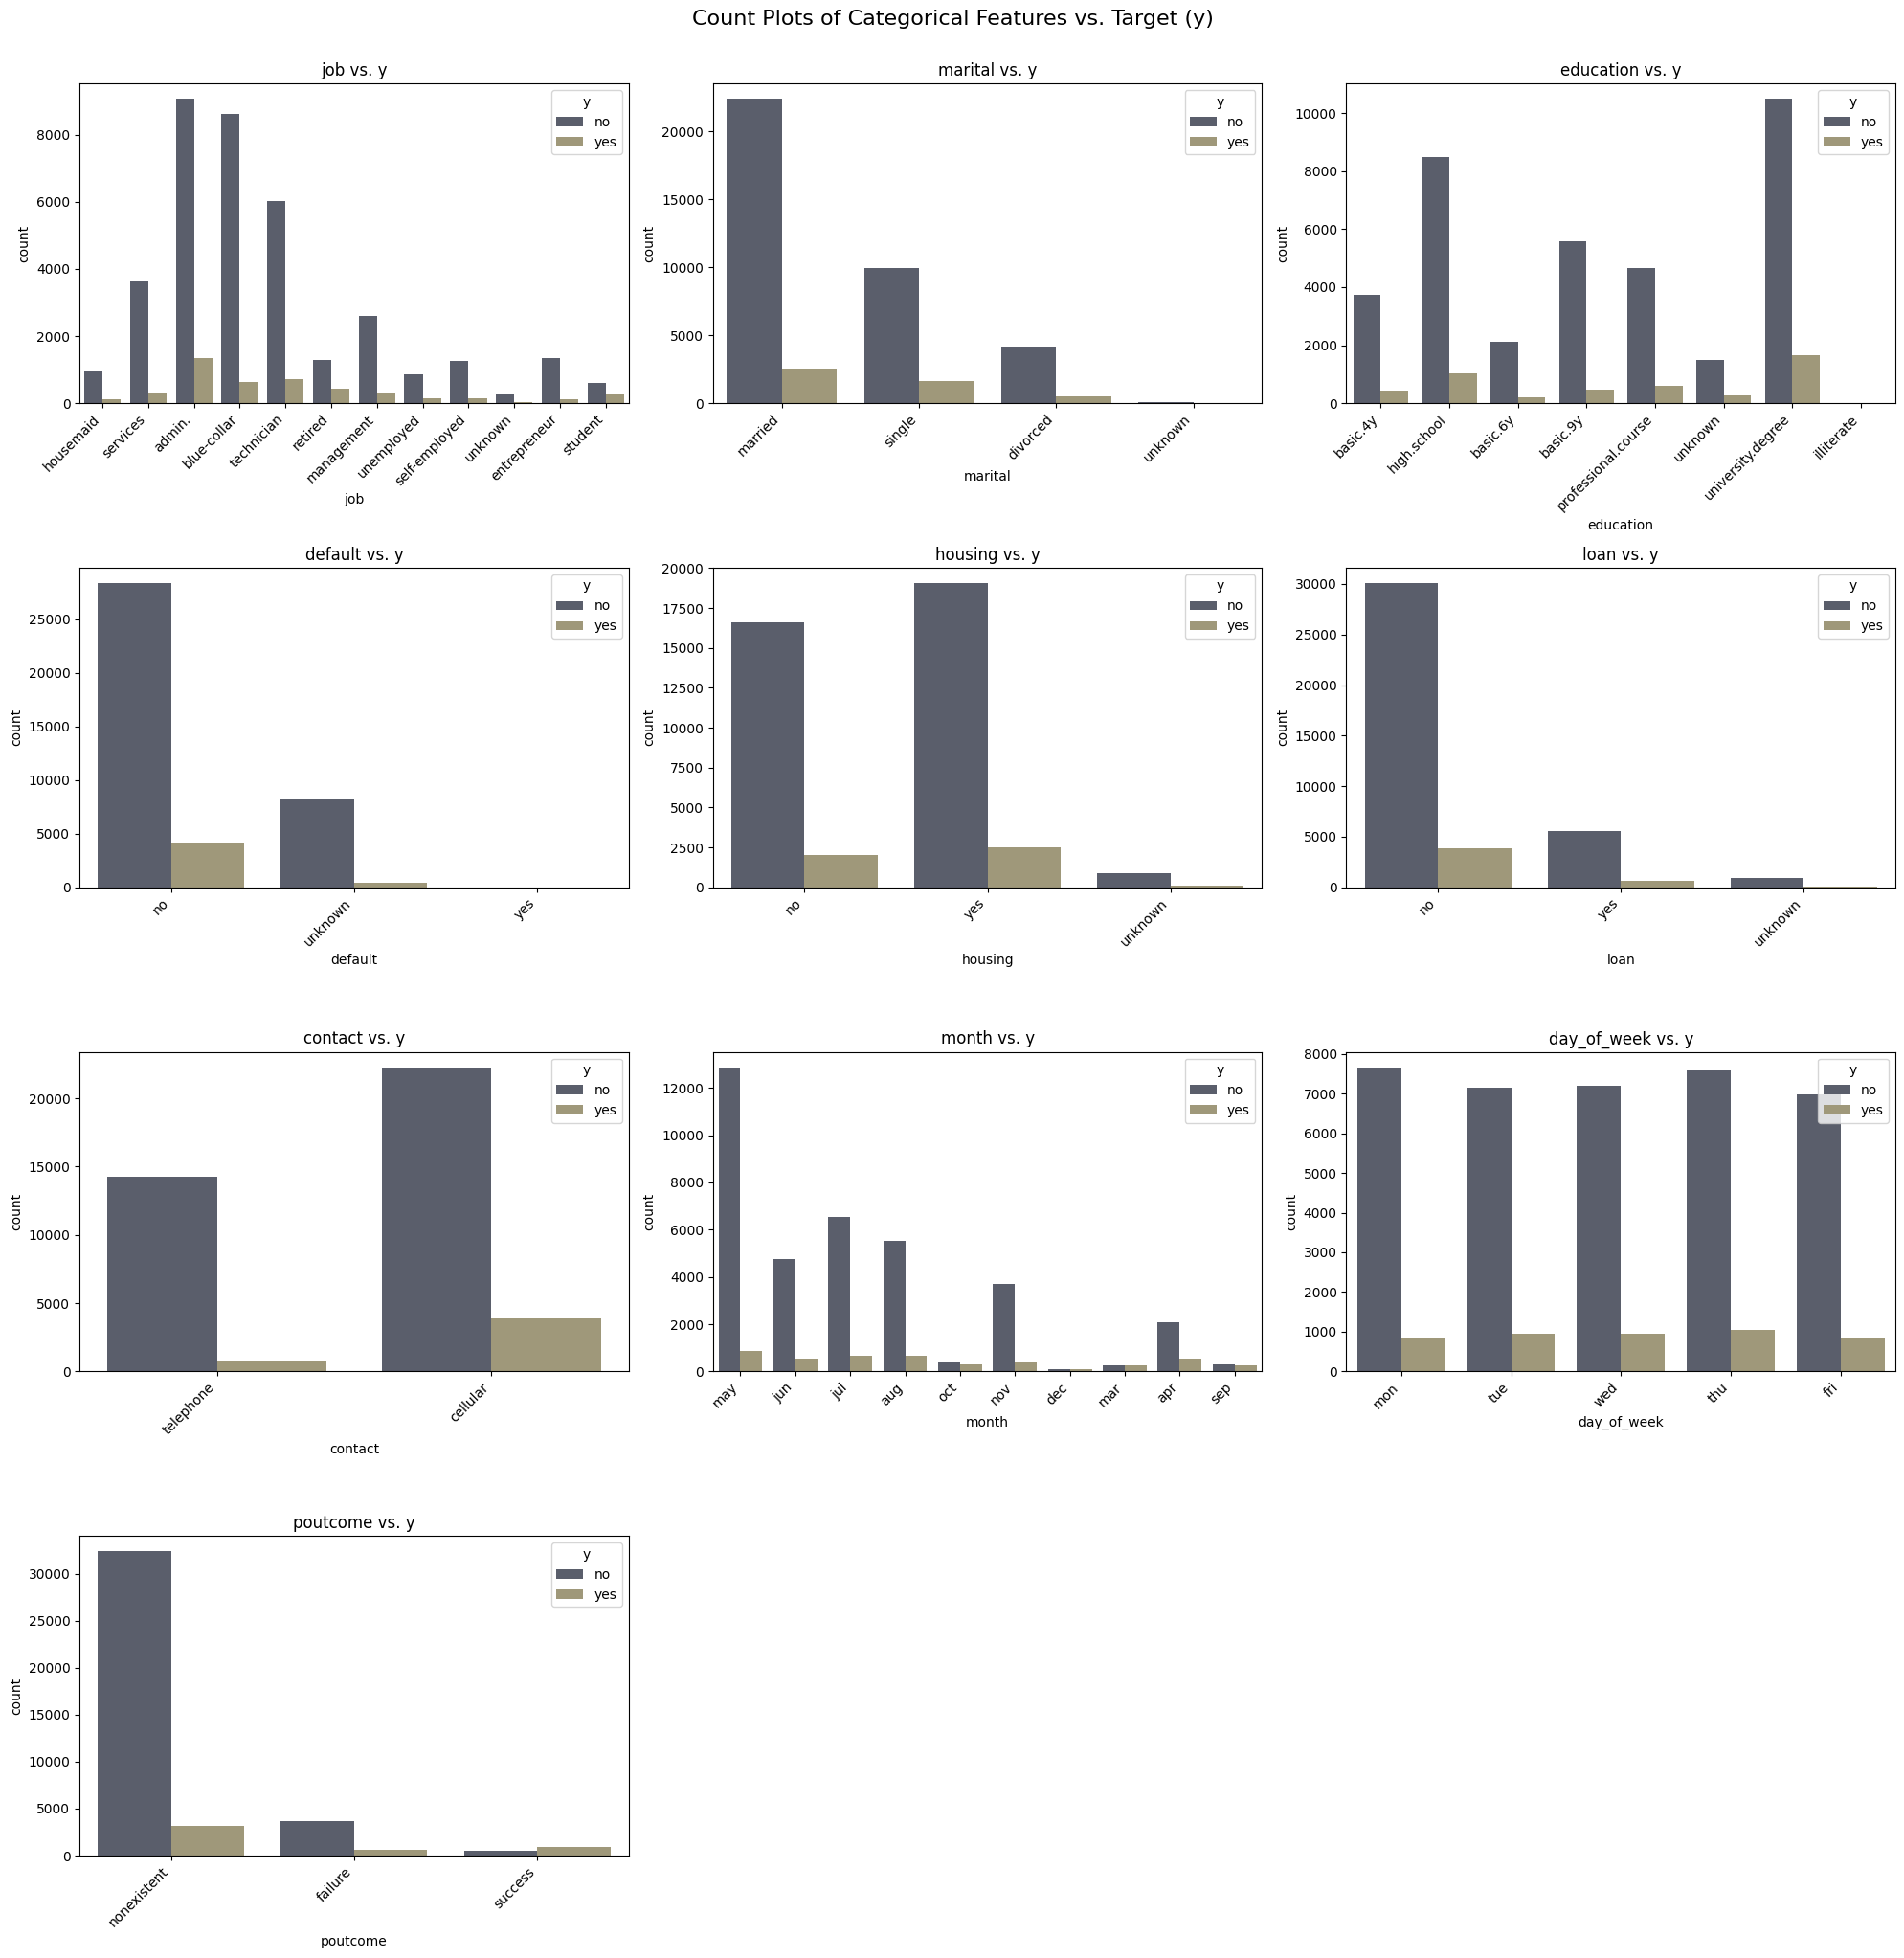

In [42]:
# --- 3.2 EDA for Categorical Features ---
print("\n--- 3.2 Value Counts for Categorical Features ---")
# List of categorical columns (excluding 'y' as it's our target)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if 'y' in categorical_cols: # 'y' will be converted to numeric later, but initially it's object
    categorical_cols.remove('y')

for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True))

# Relationship between Categorical Features and Target Variable
plt.figure(figsize=(20, 20)) # Adjusted size for more plots
for i, col in enumerate(categorical_cols):
    plt.subplot(4, 3, i + 1) # Adjusted subplot grid
    sns.countplot(x=col, hue='y', data=df, palette='cividis')
    plt.title(f'{col} vs. y')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.suptitle('Count Plots of Categorical Features vs. Target (y)', y=1.02, fontsize=16)
plt.show()

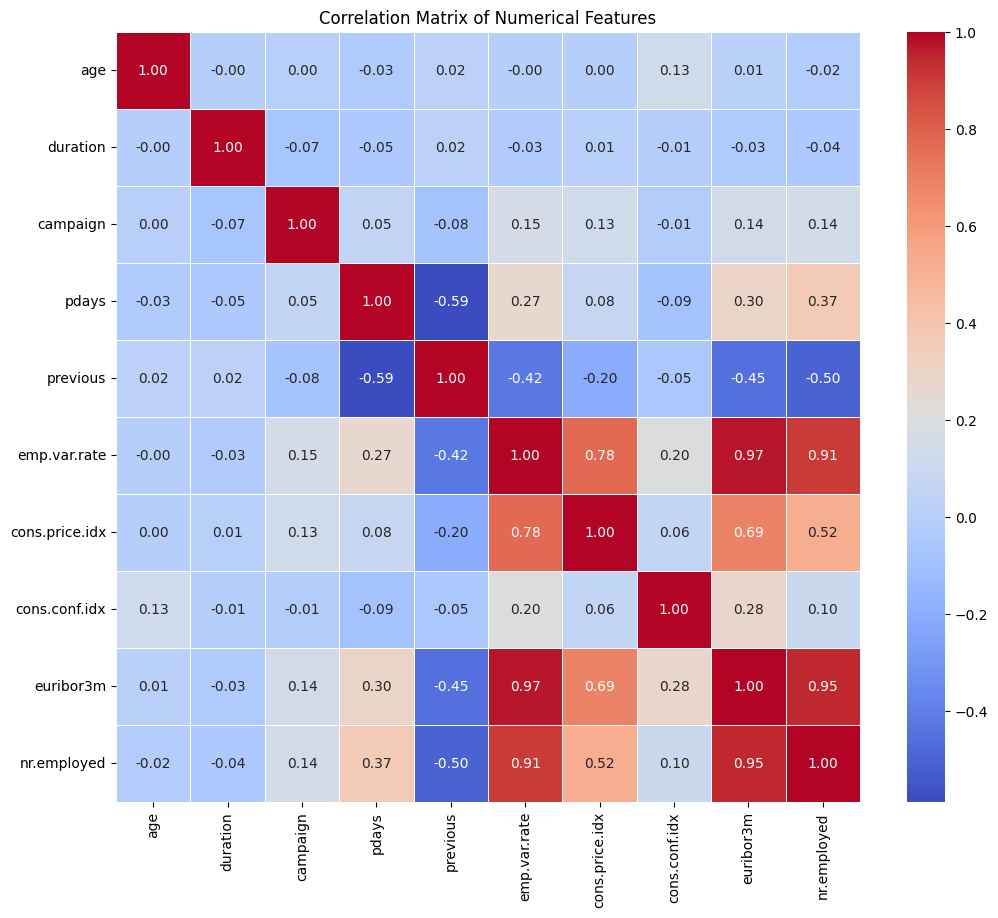

In [ ]:
# --- 3.3 Correlation Matrix for Numerical Features ---
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [30]:
# --- 4. Data Preprocessing and Splitting ---
print("\n--- Step 4: Data Preprocessing and Splitting ---")

# Convert 'y' to numerical (0 for 'no', 1 for 'yes')
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Define features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print(f"\nFinal Numerical Columns for Preprocessing: {numerical_cols}")
print(f"Final Categorical Columns for Preprocessing: {categorical_cols}")

# Split the data into training and testing sets
# Using stratify=y is crucial for maintaining class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n--- Data Split Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\n--- Target Class Distribution in Splits ---")
print(f"y_train 'yes' proportion: {y_train.value_counts(normalize=True)[1]:.4f}")
print(f"y_test 'yes' proportion: {y_test.value_counts(normalize=True)[1]:.4f}")

# Create preprocessors for numerical and categorical columns
numerical_transformer = StandardScaler() # Standardize numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # One-hot encode categorical features

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep any other columns that were not specified (e.g., if you had an ID column you wanted to pass through)
)



--- Step 4: Data Preprocessing and Splitting ---

Final Numerical Columns for Preprocessing: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Final Categorical Columns for Preprocessing: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

--- Data Split Shapes ---
X_train shape: (32950, 20)
X_test shape: (8238, 20)
y_train shape: (32950,)
y_test shape: (8238,)

--- Target Class Distribution in Splits ---
y_train 'yes' proportion: 0.1127
y_test 'yes' proportion: 0.1126


In [31]:
# --- 5. Build a Logistic Regression Model (Baseline) ---
print("\n--- Step 5: Building Baseline Logistic Regression Model ---")

# Create the full pipeline: preprocessing + classifier
# LogisticRegression uses L2 regularization by default (penalty='l2', C=1.0)
# solver='liblinear' is good for small datasets and supports L1/L2 regularization
baseline_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Train the baseline model
print("\nTraining the Baseline Logistic Regression Model...")
baseline_model_pipeline.fit(X_train, y_train)
print("Baseline Model training complete.")

# Make predictions on the test set
y_pred_baseline = baseline_model_pipeline.predict(X_test)
y_proba_baseline = baseline_model_pipeline.predict_proba(X_test)[:, 1] # Probabilities for the positive class (1: 'yes')



--- Step 5: Building Baseline Logistic Regression Model ---

Training the Baseline Logistic Regression Model...
Baseline Model training complete.



--- Step 6: Analyzing Baseline Model Performance on Test Set ---

Classification Report (Baseline Model):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.71      0.44      0.54       928

    accuracy                           0.92      8238
   macro avg       0.82      0.71      0.75      8238
weighted avg       0.91      0.92      0.91      8238


ROC AUC Score (Baseline Model): 0.9424


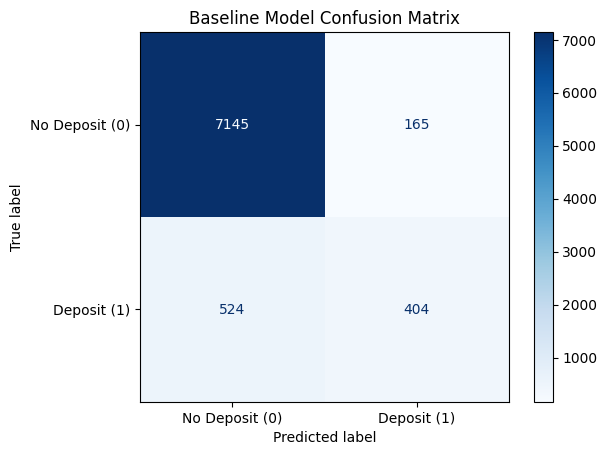

In [32]:
# --- 6. Analyze Baseline Model Performance ---
print("\n--- Step 6: Analyzing Baseline Model Performance on Test Set ---")

# Classification Report
print("\nClassification Report (Baseline Model):")
print(classification_report(y_test, y_pred_baseline))

# ROC AUC Score
roc_auc_baseline = roc_auc_score(y_test, y_proba_baseline)
print(f"\nROC AUC Score (Baseline Model): {roc_auc_baseline:.4f}")

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['No Deposit (0)', 'Deposit (1)'])
disp_baseline.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Baseline Model Confusion Matrix')
plt.show()

In [33]:
# --- 7. Optimize the Model ---
print("\n--- Step 7: Optimizing the Model ---")
print("Optimization Strategy: Addressing Class Imbalance with class_weight='balanced'")

# Create the optimized pipeline: preprocessing + classifier with class_weight='balanced'
# This automatically adjusts weights inversely proportional to class frequencies,
# giving more importance to the minority class ('yes').
optimized_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'))
])

# Train the optimized model
print("\nTraining the Optimized Logistic Regression Model...")
optimized_model_pipeline.fit(X_train, y_train)
print("Optimized Model training complete.")

# Make predictions with the optimized model
y_pred_optimized = optimized_model_pipeline.predict(X_test)
y_proba_optimized = optimized_model_pipeline.predict_proba(X_test)[:, 1]


--- Step 7: Optimizing the Model ---
Optimization Strategy: Addressing Class Imbalance with class_weight='balanced'

Training the Optimized Logistic Regression Model...


Optimized Model training complete.



--- Step 8: Analyzing Optimized Model Performance on Test Set ---

Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7310
           1       0.45      0.91      0.60       928

    accuracy                           0.87      8238
   macro avg       0.72      0.89      0.76      8238
weighted avg       0.93      0.87      0.88      8238


ROC AUC Score (Optimized Model): 0.9438


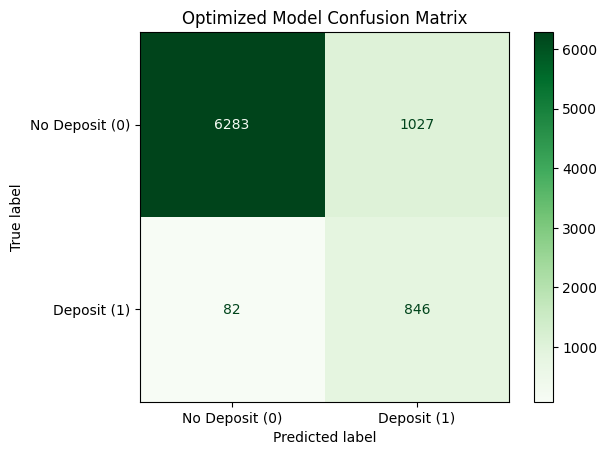

In [34]:
# --- 8. Analyze Optimized Model Performance ---
print("\n--- Step 8: Analyzing Optimized Model Performance on Test Set ---")

# Classification Report
print("\nClassification Report (Optimized Model):")
print(classification_report(y_test, y_pred_optimized))

# ROC AUC Score
roc_auc_optimized = roc_auc_score(y_test, y_proba_optimized)
print(f"\nROC AUC Score (Optimized Model): {roc_auc_optimized:.4f}")

# Confusion Matrix
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized, display_labels=['No Deposit (0)', 'Deposit (1)'])
disp_optimized.plot(cmap=plt.cm.Greens, values_format='d')
plt.title('Optimized Model Confusion Matrix')
plt.show()


Summary of My Banking Marketing Model Performance

My main goal was to find customers who will subscribe to a long-term deposit.

1. Initial Model (Baseline):

It was very good at predicting who wouldn't subscribe (almost 98% correct).

But it was poor at finding those who would subscribe: it only correctly identified 44% of them. The bank was missing many potential customers!

2. Optimized Model (using class_weight='balanced'):

The overall accuracy dropped a bit (from 92% to 87%).

But here's the key! It dramatically improved at finding those who do subscribe: it now correctly identifies 91% of them.

The trade-off was that it also predicts "yes" for more customers who will actually say "no" (precision for "yes" dropped from 71% to 45%).

Conclusion:

The optimized model is far more useful for the bank. Even though it might call more customers who aren't interested (what we call "false alarms"), the crucial point is that it now identifies almost all customers who will actually subscribe to the deposit. For a marketing campaign, it's often better to make a few extra calls than to miss out on valuable potential customers.